# Preprocessing

## Chargements des fichiers et fusion

In [136]:

#Chargement des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [137]:
# repertoire (relatif) des ficheirs de données
data_path = '../../Data'


In [138]:
#chargement des nomenclatures

#libelles : correspodnance valeur de la variable avec le libelle correspond
libelles = pd.read_csv('{}/libelles.csv'.format(data_path), sep=';', index_col=['colonne', 'indice'])

#variable : libelle complet pour chaque variable
variables = pd.read_csv('{}/variables.csv'.format(data_path), sep=';', index_col = ['variable'])


In [139]:
#chargement des données
annees = [str(x) for x in np.arange(2019,2023)]

carac = pd.DataFrame()
lieux = pd.DataFrame()
usagers = pd.DataFrame()
vehicules = pd.DataFrame()
for annee in annees : 
    carac = pd.concat([carac, pd.read_csv("{}/caracteristiques-{}.csv".format(data_path, annee), sep=';', dtype=object)])
    lieux = pd.concat([lieux, pd.read_csv("{}/lieux-{}.csv".format(data_path, annee), sep=';', dtype=object)])
    usagers = pd.concat([usagers, pd.read_csv("{}/usagers-{}.csv".format(data_path, annee), dtype=object,sep=';')])
    vehicules = pd.concat([vehicules, pd.read_csv("{}/vehicules-{}.csv".format(data_path, annee), sep=';', dtype=object)])


In [140]:
#correction identifiant accident
carac['Num_Acc'] = carac['Num_Acc'].fillna(carac['Accident_Id'])
carac = carac.drop('Accident_Id', axis = 1)

#jointure carac-lieux
df = pd.merge(left = carac, right = lieux, left_on = 'Num_Acc', right_on='Num_Acc')

#jointure df-vehicules
df = pd.merge(left=df, right=vehicules, left_on='Num_Acc', right_on='Num_Acc')

#jointure df-usagers
df = pd.merge(left=df, right=usagers, right_on='id_vehicule', left_on='id_vehicule')

#suppression des identifiants
df = df.drop(['Num_Acc_x', 'id_vehicule', 'num_veh_x', 'Num_Acc_y','num_veh_y', 'id_usager'], axis = 1)

## Corrections des données

In [141]:
#recodage dess données manquantes en nan
df = df.replace({
    '-1':np.nan,
    -1:np.nan,
    ' -1':np.nan,
    '#ERREUR':np.nan
})


In [142]:
#secu  : un champ binaire par équipement
for i in range(1,10) :
    df['secu_'+str(i)] = ((df['secu1']==i) | (df['secu2']==i) | (df['secu3']==i))*1

df = df.drop(['secu1','secu2','secu3'], axis = 1)

In [143]:
pd.DataFrame({'column_name': df.columns,'percent_missing': df.isnull().sum() * 100 / len(df)}).sort_values('percent_missing', ascending=False).head(5)


,column_name,percent_missing
lartpc,lartpc,99.781052
occutc,occutc,98.742973
larrout,larrout,95.380649
etatp,etatp,92.323476
v2,v2,91.998494


In [144]:
#elimination des colonnes avec plus de 25% de valeurs manquantes
df = df.dropna(thresh=len(df)*3/4, axis = 1)

In [145]:
#suppression des lignes sans variable d'Interet
df = df.dropna(subset=['grav'])

In [146]:
# suppression de l'adresse qui ne sert à rien
df = df.drop('adr', axis = 1)

In [147]:
#suppression des variables de dénomination des voies ininterprétables
df = df.drop(['voie','v1'], axis = 1)

In [148]:
df.isna().sum(axis = 1).sum()/len(df)

0.1438342434716055

In [149]:
#suppression des lignes ayant au mojns une valeur nulle (#14%)
df = df.dropna(how = 'any', axis=0)

In [150]:
#restent 442989 lignes
df.shape

(442989, 47)

In [151]:
#conversion des latitudes et longitudes
df['lat']= df['lat'].str.replace(',','.').astype('float')
df['long']= df['long'].str.replace(',','.').astype('float')


In [152]:
#on ajoute un créneau horaire
df['hh'] = df['hrmn'].str[:2]

df = df.drop('hrmn', axis = 1)

In [153]:
#conversion en entier
df['hh'] = df['hh'].astype('int')

In [154]:
df['mois'] = df['mois'].astype(int)

In [155]:
#on ajoute une variablme binaire indiquant semaine ou weekend
df['weekend']=(pd.to_datetime(dict(day=df['jour'], month=df['mois'].astype(int), year=df['an'])).dt.weekday>=5)*1

In [156]:
#calcul de l'age des usagers dans l'année de l'accident
df['age'] = df['an'].astype(int) - df['an_nais'].astype(int)

df = df.drop('an_nais', axis = 1)

In [157]:
#suppression des jours et années
df = df.drop(['jour','an'], axis = 1)

In [158]:
# suppression des varaible de localisation (on utilsaera la géolocalisation) et des varaibles diffficilement interprétabes
df = df.drop(['pr','pr1', 'senc', 'dep'], axis = 1)

In [159]:
df.shape

(442989, 42)

In [160]:
# Conversion des variables catégorielles en entiers
df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']] = df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']].astype('int')

In [161]:
#recodage de la gravité : indice croissant
"""
Av => apr => label
1 => 0 => Indemme
4 => 1 => Blessé léger
3 => 2 => Blessé hospitalisé
2 => 3 => Tué
"""

df['grav']=df['grav'].replace({1:0})
df['grav']=df['grav'].replace({4:1})

df['grav']=df['grav'].replace({3:5})
df['grav']=df['grav'].replace({2:3})
df['grav']=df['grav'].replace({5:2})

## Géolocalisation

In [162]:
#corrections coordonnées martinique
# coordonnées inversées
idx = (df['com'].str[0:3] == '972' ) &  (df['long'].between(14,15) & (df['lat'].between(-62,-61) ))
df.loc[idx, ['lat','long']] = df.loc[idx, ['long','lat']].values

# longitude 16 <=> 61
idx = (df['com'].str[0:3] == '972' ) & ( (df['long']==16 ))
df.loc[idx, 'long'] = 61

#longitude positive <=> négative
idx = (df['com'].str[0:3] == '972' ) & ( (df['long']> 0 ))
df.loc[idx, 'long'] = -df['long']

#coordonnées saint pierre erronées : on remplace par le mode
m_lat = df.loc[df['com']=='97213','lat'].mode()
m_long = df.loc[df['com']=='97213','long'].mode()

idx = (df['com'] == '97213' ) & (df['long'] == -1.407665)

df.loc[idx,'lat'] = m_lat[0]
df.loc[idx, 'long'] = m_long[0] 

# correction de la longitude erronée pour la guadeloupe
idx = (df['com'].str[0:3] == '971' ) & ( (df['long']> 0 ))
df.loc[idx, 'long'] = - df['long']


In [172]:
df[df['lat'].between(18,18.1)]

,mois,lum,com,agg,int,atm,col,lat,long,catr,...,secu_3,secu_4,secu_5,secu_6,secu_7,secu_8,secu_9,hh,weekend,age
7526,10,1,97801,1,3,1,3,18.098950,-63.051569,2,...,0,0,0,0,0,0,0,12,0,37
7527,10,1,97801,1,3,1,3,18.098950,-63.051569,2,...,0,0,0,0,0,0,0,12,0,17
11949,8,2,97801,2,1,1,4,18.095799,-63.035159,2,...,0,0,0,0,0,0,0,19,1,4
11950,8,2,97801,2,1,1,4,18.095799,-63.035159,2,...,0,0,0,0,0,0,0,19,1,26
11951,8,2,97801,2,1,1,4,18.095799,-63.035159,2,...,0,0,0,0,0,0,0,19,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476463,1,1,97801,1,9,1,3,18.099263,-63.062189,2,...,0,0,0,0,0,0,0,17,1,25
491232,5,1,97801,2,1,1,3,18.068106,-63.085492,4,...,0,0,0,0,0,0,0,13,1,36
491233,5,1,97801,2,1,1,3,18.068106,-63.085492,4,...,0,0,0,0,0,0,0,13,1,28
491234,5,1,97801,2,1,1,3,18.068106,-63.085492,4,...,0,0,0,0,0,0,0,13,1,47


In [124]:

#suppression du code commune
df = df.drop('com', axis = 1)

## Statistiques

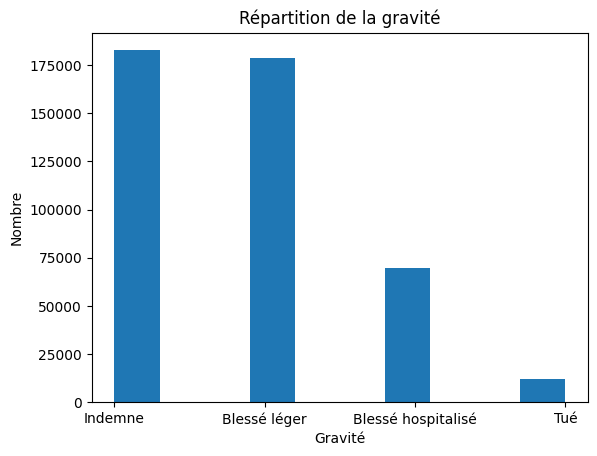

In [125]:
gravite = ['Indemne','Blessé léger', 'Blessé hospitalisé', 'Tué',]

df['grav'].astype('str').sort_values().hist(grid=False)
plt.title('Répartition de la gravité')
plt.ylabel('Nombre')
plt.xlabel('Gravité')
plt.xticks(ticks=['0','1','2','3'],labels=gravite);

In [126]:
for v in df.select_dtypes('int').columns :
    cont = pd.crosstab(df[v], df['grav'])
    print(v , chi2_contingency(cont).pvalue)
    

mois 3.7209049978151205e-90
lum 0.0
int 0.0
atm 7.916281360525653e-306
col 0.0
circ 0.0
nbv 0.0
vosp 8.151900559932659e-258
prof 0.0
plan 0.0
surf 1.5559956127296118e-174
infra 5.910429278433572e-197
situ 0.0
vma 0.0
catv 0.0
obs 0.0
obsm 0.0
choc 0.0
manv 0.0
motor 0.0
place 0.0
grav 0.0
sexe 0.0
trajet 0.0
secu_1 1.0
secu_2 1.0
secu_3 1.0
secu_4 1.0
secu_5 1.0
secu_6 1.0
secu_7 1.0
secu_8 1.0
secu_9 1.0
hh 0.0
weekend 1.311599964330357e-226
age 0.0


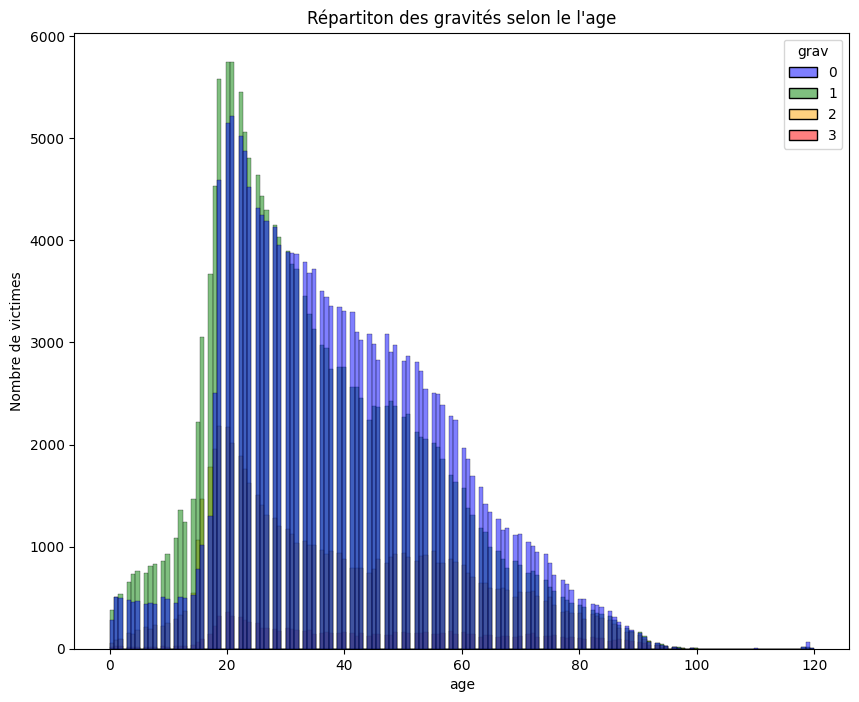

In [127]:
sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
        
g = sns.histplot(data=df, x='age',  hue='grav', palette=palette)
g.figure.set_size_inches(10,8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le l\'age');

In [128]:
#création de classes d'ages à la place de la variable numérique age
bins = [0,10,18,25,45,65,999]
labels=[0,1,2,3,4,5]
df['classe_age'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

In [129]:
df = df.drop('age', axis = 1)

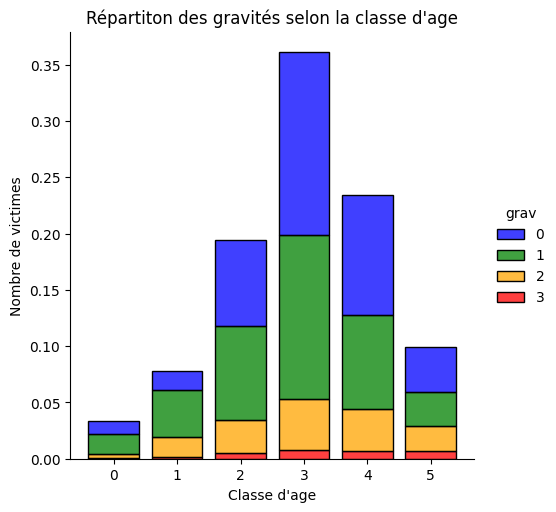

In [130]:
sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
        
sns.displot(data=df, x='classe_age',  hue='grav', palette=palette, multiple='stack', bins = 6, shrink=.8, stat='density')
plt.ylabel('Nombre de victimes')
plt.xlabel('Classe d\'age')
plt.title('Répartiton des gravités selon la classe d\'age');

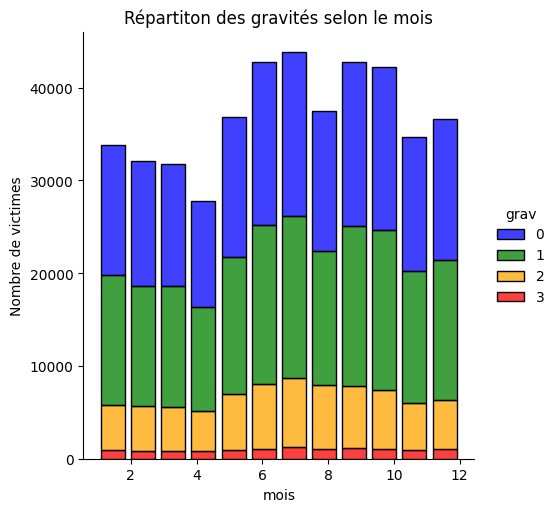

In [131]:

sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
        
sns.displot(data=df.sort_values(by='mois'), x='mois',  hue='grav', palette=palette, multiple='stack', bins = 12, shrink=.8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le mois');

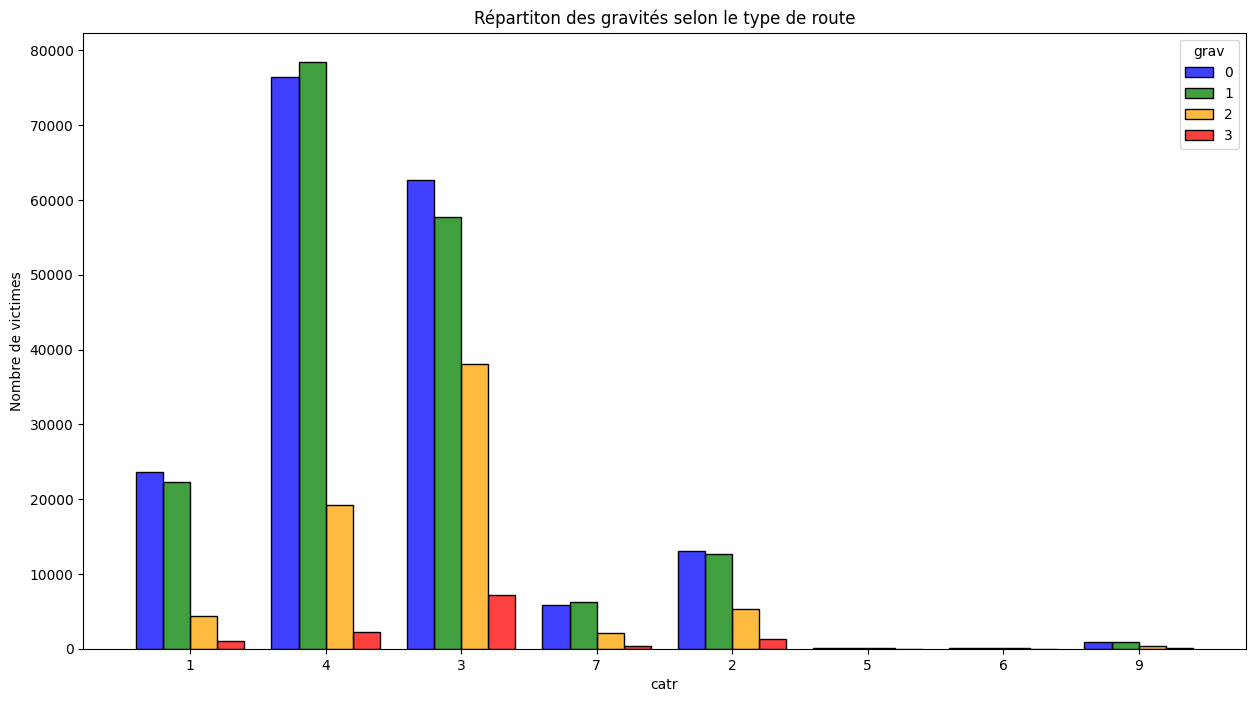

In [132]:
plt.figure(figsize=(15,8))
sns.color_palette("Paired")
palette = ['blue','green','orange','red']
        
#sns.displot(data=df, x='catr', kind='hist', hue='grav', palette=palette, multiple='dodge', bins=9, rwidth=0.7)
sns.histplot(data=df, x='catr',  hue='grav', palette=palette, multiple='dodge', bins=9, shrink=.8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le type de route');

In [133]:
# dernières conversion
df[['mois','agg','catr','catu','classe_age']] = df[['mois','agg','catr','catu','classe_age']].astype(int)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442989 entries, 0 to 494180
Data columns (total 41 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mois        442989 non-null  int32  
 1   lum         442989 non-null  int32  
 2   agg         442989 non-null  int32  
 3   int         442989 non-null  int32  
 4   atm         442989 non-null  int32  
 5   col         442989 non-null  int32  
 6   lat         442989 non-null  float64
 7   long        442989 non-null  float64
 8   catr        442989 non-null  int32  
 9   circ        442989 non-null  int32  
 10  nbv         442989 non-null  int32  
 11  vosp        442989 non-null  int32  
 12  prof        442989 non-null  int32  
 13  plan        442989 non-null  int32  
 14  surf        442989 non-null  int32  
 15  infra       442989 non-null  int32  
 16  situ        442989 non-null  int32  
 17  vma         442989 non-null  int32  
 18  catv        442989 non-null  int32  
 19  obs    

In [135]:
#sauvegarde du fichier
df.to_csv('{}/accidents.csv'.format(data_path), index = False)